Mounting google drive for dataset access and saving models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change the current working directory to the 'drive/MyDrive/Colab Notebooks/ViT/' folder

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ViT')

Train the model

In [1]:
!python train.py

27000 images were found in the dataset.
21600 images for training.
5400 images for validation.
Using 8 dataloader workers every process
_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])
[valid epoch 19] loss: 0.031, acc: 0.990: 100%|█| 22/22 [00:08<00:00,  2.48it/s]


Load the TensorBoard notebook extension.

In [2]:
%load_ext tensorboard

Open the TensorBoard panel to view loss and prediction accuracy graphs for the training and testing process.

In [3]:
%tensorboard --logdir=runs

Write a function that predicts land use and land cover for a given input image based on the weights of the trained model.

In [4]:
# import the necessary libraries
import os
import json
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
# import the model
from vit_model import vit_base_patch16_224 as create_model

def predict_and_show_image(image_path):
    # Check if CUDA (GPU) is available, and if so, sets the device to GPU; otherwise, it sets the device to CPU.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Sets the size of the image to 64x64 pixels.
    img_size = 224

    # Defines a series of preprocessing operations for the image, including resizing, center cropping, converting to a tensor, and normalization.
    data_transform = transforms.Compose(
        [transforms.Resize(int(img_size * 1.14)),
         transforms.CenterCrop(img_size),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    assert os.path.exists(image_path), "File '{}' does not exist.".format(image_path)
    img = Image.open(image_path)
    img_original = img.copy()  # Save the original image for display
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)
    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # Create the model
    model = create_model(num_classes=10).to(device)
    # Load model weights
    model_weight_path = "./weights_vit/best.pth"
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    model.eval()

    # Perform prediction
    with torch.no_grad():
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    # Display the image with predicted class label as title
    plt.imshow(img_original)
    plt.title("Predicted Class: {}".format(class_indict[str(predict_cla)]))
    plt.axis('off')  # Turn off axis
    plt.show()

And test the prediction result based on the input image.

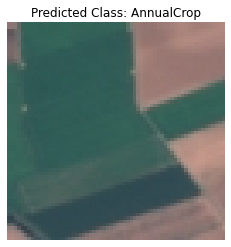

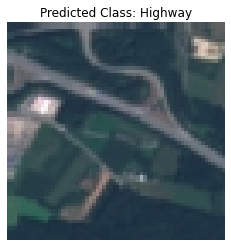

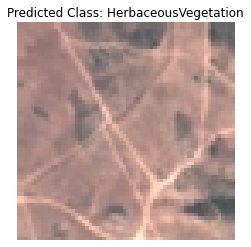

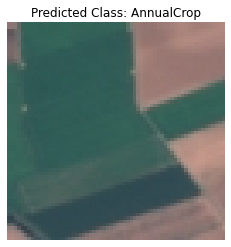

In [5]:
# Input an image and predict its category.
# Below are 4 examples of tests.
image_file = "./2750/AnnualCrop/AnnualCrop_7.jpg"
predict_and_show_image(image_file)

image_file = "./2750/Highway/Highway_3.jpg"
predict_and_show_image(image_file)

image_file = "./2750/HerbaceousVegetation/HerbaceousVegetation_7.jpg"
predict_and_show_image(image_file)

image_file = "./2750/AnnualCrop/AnnualCrop_7.jpg"
predict_and_show_image(image_file)

**Confusion matrix of the test set.**
Import the necessary libraries.

In [8]:
# import the necessary libraries
import os
import json
import argparse
import sys
import torch
from torchvision import transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from utils import read_split_data
from my_dataset import MyDataSet
from vit_model import vit_base_patch16_224 as create_model

**Confusion matrix of the test set.**
Define a class to compute and visualize the confusion matrix.

In [9]:
class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # Set x-axis coordinate label
        plt.xticks(range(self.num_classes), self.labels, rotation=90)
        # Set y-axis coordinate label
        plt.yticks(range(self.num_classes), self.labels)
        # show colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        # Annotate quantity/probability information in the graph
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()

**Confusion matrix of the test set.**
Define the main function of the script. Inside this function, the following steps are performed:

The device (GPU or CPU) is selected based on availability.
Paths to test images and their labels are obtained.
Data transformations for test images are defined.
The test dataset is instantiated using the provided paths and transformations.
DataLoader for test dataset is created with specified batch size and number of workers.
The model is created and loaded with trained weights.
Class indices are read from a JSON file.
Confusion matrix object is instantiated.
Model is set to evaluation mode, and test dataset is iterated over.
Predictions are made on test data, and confusion matrix is updated.
Finally, the confusion matrix is plotted and summarized.

In [12]:
def main(args):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")

    _, _, val_images_path, val_images_label = read_split_data(args.data_path)

    img_size = 224
    data_transform = {
        "val": transforms.Compose([transforms.Resize(int(img_size * 1.143)),
                                   transforms.CenterCrop(img_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    # Instantiate the validation dataset
    val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

    nw = min([os.cpu_count(), args.batch_size if args.batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=args.batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)

    model = create_model(num_classes=args.num_classes)
    # load pretrain weights
    assert os.path.exists(args.weights), "cannot find {} file".format(args.weights)
    model.load_state_dict(torch.load(args.weights, map_location=device))
    model.to(device)

    # read class_indict
    json_label_path = './class_indices.json'
    assert os.path.exists(json_label_path), "cannot find {} file".format(json_label_path)
    json_file = open(json_label_path, 'r')
    class_indict = json.load(json_file)

    labels = [label for _, label in class_indict.items()]
    confusion = ConfusionMatrix(num_classes=args.num_classes, labels=labels)
    model.eval()
    with torch.no_grad():
        for val_data in tqdm(val_loader, file=sys.stdout):
            val_images, val_labels = val_data
            outputs = model(val_images.to(device))
            outputs = torch.softmax(outputs, dim=1)
            outputs = torch.argmax(outputs, dim=1)
            confusion.update(outputs.to("cpu").numpy(), val_labels.to("cpu").numpy())
    confusion.plot()
    confusion.summary()

**Confusion matrix of the test set.**
This block is the entry point of the script. It checks if the script is being run directly as the main program.

using device: cuda:0
27000 images were found in the dataset.
21600 images for training.
5400 images for validation.
Using 8 dataloader workers every process
100%|██████████| 85/85 [00:08<00:00,  9.88it/s]
[[576.  57.   1.   0.   0.   4.   4.   0.   1.   0.]
 [  0. 181.   3.   0.   0.   1.   0.   0.   0.   2.]
 [  0. 192. 558.   1.   0.   7.  12.   0.   4.   1.]
 [  4.   0.   2. 497.   2.   5.  10.   0.   8.   0.]
 [  4.   0.   2.   1. 496.   0.  35.   5.   3.   0.]
 [  1.   1.   7.   0.   0. 371.   0.   0.   4.   0.]
 [ 10.   2.   4.   0.   0.   6. 423.   0.   0.   0.]
 [  0.  31.  21.   0.   2.   0.  15. 595.   0.   0.]
 [  5.  13.   0.   1.   0.   5.   1.   0. 480.   2.]
 [  0. 123.   2.   0.   0.   1.   0.   0.   0. 595.]]


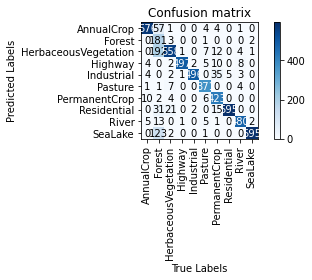

the model accuracy is  0.8837037037037037
+----------------------+-----------+--------+-------------+
|                      | Precision | Recall | Specificity |
+----------------------+-----------+--------+-------------+
|      AnnualCrop      |   0.896   |  0.96  |    0.986    |
|        Forest        |   0.968   | 0.302  |    0.999    |
| HerbaceousVegetation |    0.72   |  0.93  |    0.955    |
|       Highway        |   0.941   | 0.994  |    0.994    |
|      Industrial      |   0.908   | 0.992  |     0.99    |
|       Pasture        |   0.966   | 0.928  |    0.997    |
|    PermanentCrop     |   0.951   | 0.846  |    0.996    |
|     Residential      |   0.896   | 0.992  |    0.986    |
|        River         |   0.947   |  0.96  |    0.994    |
|       SeaLake        |   0.825   | 0.992  |    0.974    |
+----------------------+-----------+--------+-------------+


In [13]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_classes', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=64)

    # The directory where the data set is located
    parser.add_argument('--data-path', type=str, default="2750")

    # # Pretrained weight path
    parser.add_argument('--weights', type=str, default='./weights_vit/best.pth', help='initial weights path')
    # Whether to freeze the weights
    parser.add_argument('--device', default='cuda:0', help='device id (i.e. 0 or 0,1 or cpu)')

    opt = parser.parse_args(args=[])

    main(opt)